# Cuda Simulator

In [1]:
"""Setup"""
# DONE
import numpy as np
#from google.colab import drive
from viz_cuda import *
from optics_cuda import *

#drive.mount("/content/gdrive")
#np.set_printoptions(
#    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
#)

CuPy version 11.0.0


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
%%time
# DONE
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""

photon_count = np.int32(30000000)
source_size = np.float32(10)
photons = LambertianSource(source_size, source_size).make_photons(photon_count)
print(f"LED emitted photons: {photons.size()}")

LED emitted photons: 30000000
CPU times: user 246 ms, sys: 40.4 ms, total: 287 ms
Wall time: 306 ms


CPU times: user 101 ms, sys: 938 µs, total: 102 ms
Wall time: 102 ms


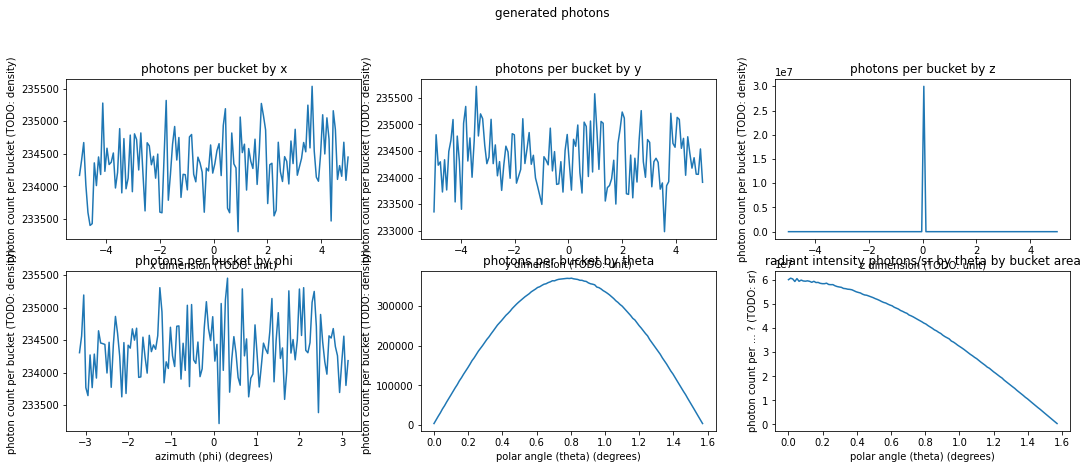

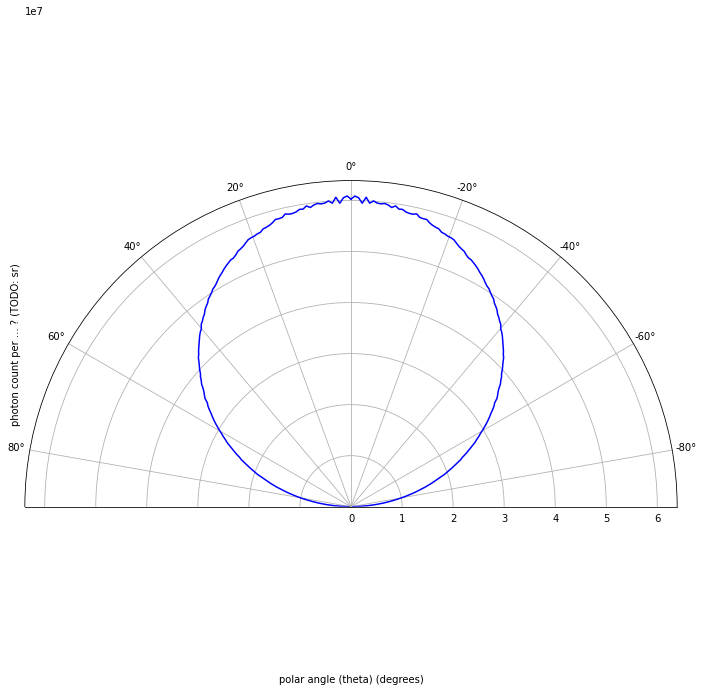

In [3]:
%%time
# DONE
""" Look at the distributions of the generated photons."""
plot_histogram_slices(photons, "generated photons",
                      x_min = -source_size/2, x_max = source_size/2,
                      y_min = -source_size/2, y_max = source_size/2,
                      z_min = -5, z_max = 5,
                      theta_max = np.pi/2)

In [4]:
%%time
#DONE
source_sample = photons.sample()

CPU times: user 0 ns, sys: 3.01 ms, total: 3.01 ms
Wall time: 2.41 ms


In [5]:
%%time
#DONE
"""Look at the photons in 3d."""
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
plot_3d([source_sample], ray_lengths=[1], boxes=[source_box], labels=['LED'], colors=[0xffff00])

Output()

CPU times: user 27.1 ms, sys: 440 µs, total: 27.6 ms
Wall time: 24.2 ms


In [6]:
%%time
# DONE
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
###

lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {photons.size()}")

diffuser incident photons: 25345910
CPU times: user 4.93 s, sys: 17.9 ms, total: 4.95 s
Wall time: 4.97 s


In [7]:
# DONE
box_sample = photons.sample()

In [8]:
%%time
#DONE
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
plot_3d([source_sample, box_sample], ray_lengths=[100, 100],
        boxes=[source_box, lightbox_box], labels=['LED','lightbox'], colors=[0xffff00, 0x00ffff])

Output()

CPU times: user 36.1 ms, sys: 184 µs, total: 36.3 ms
Wall time: 32.7 ms


CPU times: user 99.6 ms, sys: 151 µs, total: 99.7 ms
Wall time: 97.4 ms


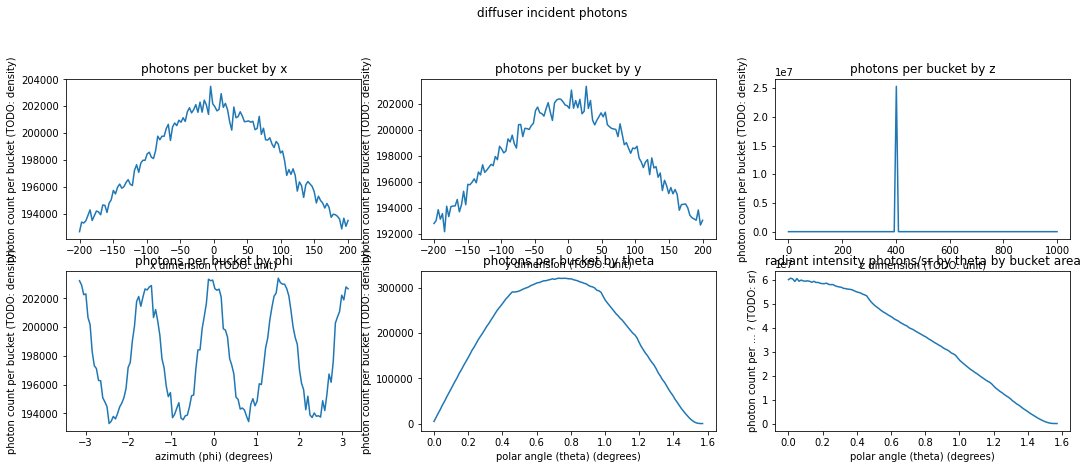

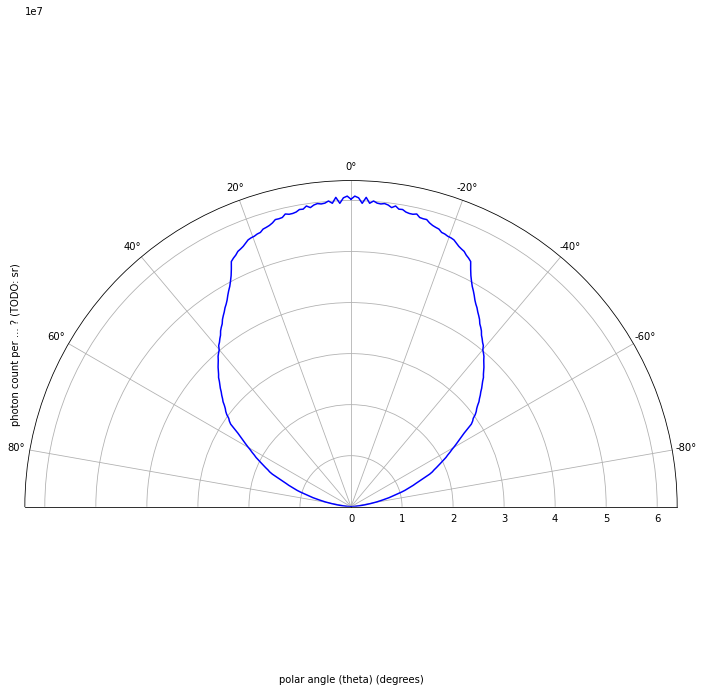

In [9]:
%%time
#DONE
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi/2)

In [10]:
%%time
# DONE
""" Diffuse through the diffuser. """
diffuser = Diffuser(g = np.float32(0.64), absorption = np.float32(0.16))
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {photons.size()}")

diffuser-transmitted photons: 21294008
CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 103 ms


CPU times: user 138 ms, sys: 4.17 ms, total: 142 ms
Wall time: 138 ms


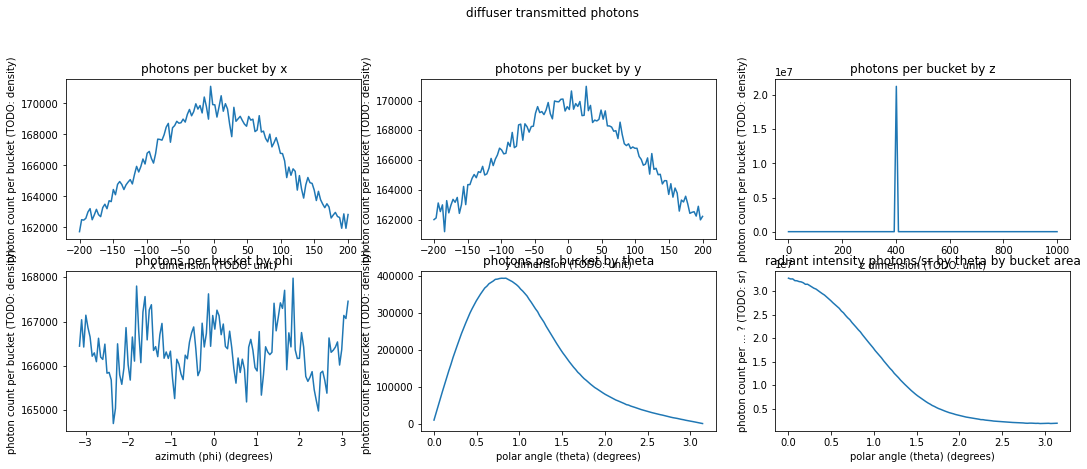

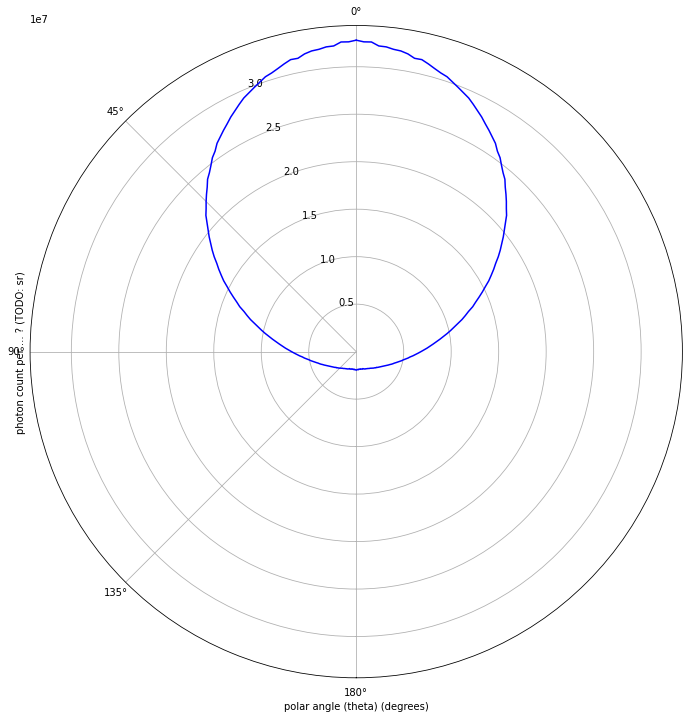

In [11]:
%%time
# DONE
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi)

In [12]:
%%time
# DONE
diff_sample = photons.sample()

CPU times: user 909 µs, sys: 47 µs, total: 956 µs
Wall time: 483 µs


In [13]:
%%time
# DONE
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
diff_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height+1]
plot_3d([source_sample, box_sample, diff_sample],
        ray_lengths=[10, 10, 100],
        boxes=[source_box, lightbox_box, diff_box],
        labels=['LED', 'lightbox', 'diffuser'],
        colors=[0xffff00, 0x00ffff, 0xff00ff])

Output()

CPU times: user 58.1 ms, sys: 32 ms, total: 90.1 ms
Wall time: 45.2 ms


In [14]:
%%time
#DONE
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# TODO: units.
# for now, unit is 100 microns, so
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# reflector size might be 10cm square (=1000)

reflector_distance = np.float32(100000)
#reflector_distance = np.float32(50000)
#reflector_distance = np.float32(10000)
propagate_to_reflector(photons, location = reflector_distance, size = np.float32(1000))
prune_outliers(photons, size = np.float32(1000))
print(f"reflector-incident photons: {photons.size()}")

reflector-incident photons: 528
CPU times: user 119 ms, sys: 99 µs, total: 119 ms
Wall time: 118 ms


CPU times: user 102 ms, sys: 77 µs, total: 102 ms
Wall time: 102 ms


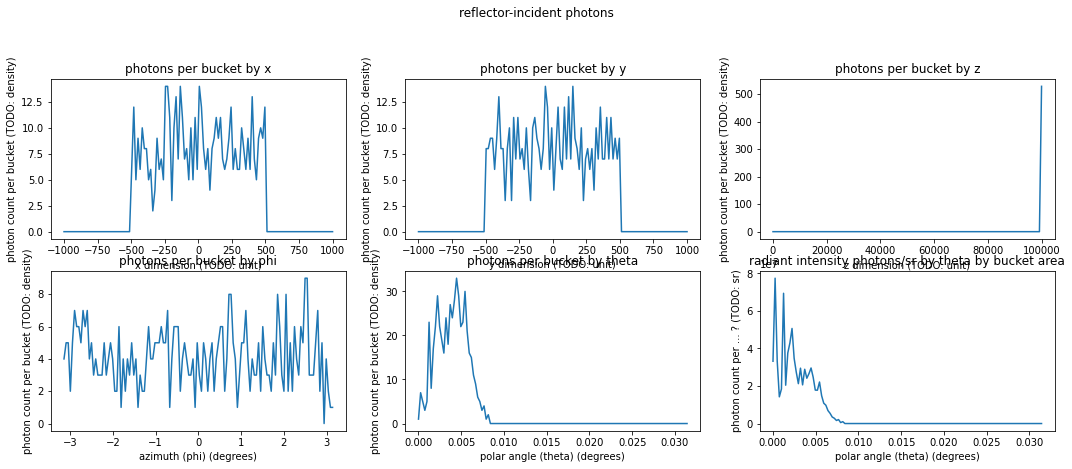

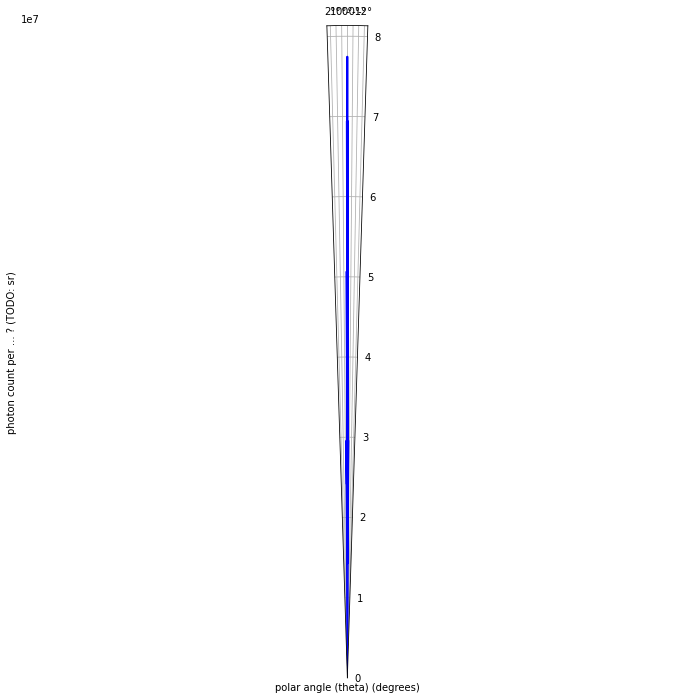

In [15]:
%%time
# DONE
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons",
                      x_min=-1000, x_max=1000,
                      y_min=-1000, y_max=1000,
                      z_min=0, z_max=reflector_distance,
                     theta_max = np.pi/100)

In [16]:
%%time
# DONE
reflector_sample = photons.sample()

CPU times: user 0 ns, sys: 2.44 ms, total: 2.44 ms
Wall time: 773 µs


In [17]:
%%time
# DONE
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
print(f"reflector-incident photons: {photons.size()}")
plot_3d([source_sample, box_sample, diff_sample],
        ray_lengths=[10, 10, 100],
        boxes=[source_box, lightbox_box, diff_box],
        labels=['LED', 'lightbox', 'diffuser'],
        colors=[0xffff00, 0x00ffff, 0xff00ff])
reflector_box = [-500, 500, -500, 500, reflector_distance]
plot_3d([reflector_sample],
        ray_lengths=[100],
        boxes=[reflector_box],
        labels=['reflector'],
        colors=[0x808000])

reflector-incident photons: 528


Output()

Output()

CPU times: user 89.7 ms, sys: 28 ms, total: 118 ms
Wall time: 69.6 ms


In [18]:
%%time
# DONE
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {photons.size()}")
# TODO: guess at absorption
reflector = Diffuser(g = np.float32(-0.9925), absorption=np.float32(0.0))
reflector.diffuse(photons)
print(f"reflected photons: {photons.size()}")

reflector-incident photons: 528
reflected photons: 528
CPU times: user 1.17 ms, sys: 49 µs, total: 1.22 ms
Wall time: 743 µs


CPU times: user 99.6 ms, sys: 0 ns, total: 99.6 ms
Wall time: 98.1 ms


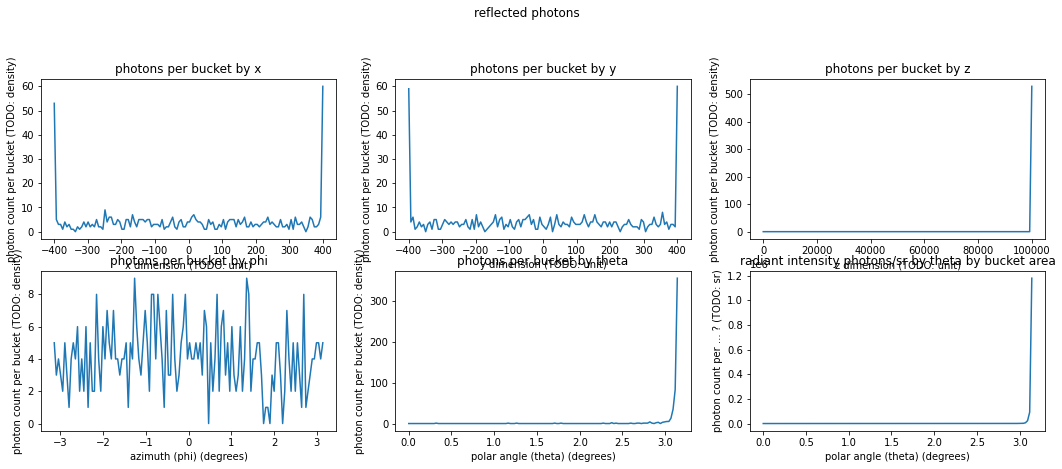

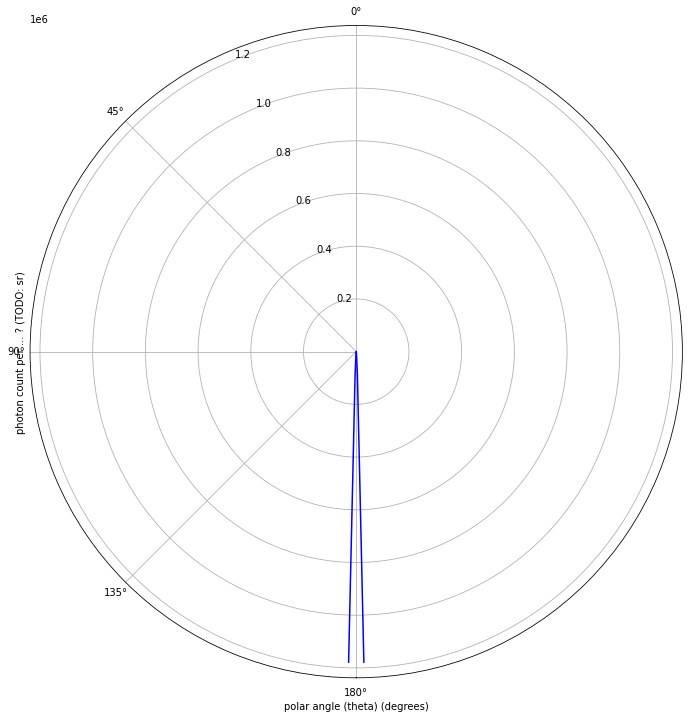

In [19]:
%%time
# DONE
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", 
                      x_min=-400, x_max=400, 
                      y_min=-400, y_max=400, z_min=0,
                      z_max=reflector_distance)

In [20]:
%%time
#DONE
reflected_sample = photons.sample()

CPU times: user 1.52 ms, sys: 111 µs, total: 1.63 ms
Wall time: 1.15 ms


In [21]:
%%time
#DONE
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
reflected_box = [-500, 500, -500, 500, reflector_distance - 1]
plot_3d([reflector_sample, reflected_sample],
        ray_lengths=[100, 100],
        boxes=[reflector_box, reflected_box],
        labels=['reflector', 'reflected'],
        colors=[0x808000, 0x008080])

Output()

CPU times: user 54.3 ms, sys: 4.47 ms, total: 58.7 ms
Wall time: 43.8 ms


In [22]:
%%time
#DONE
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {photons.size()}")
camera_distance = np.float32(lightbox_height) # make the camera height even with the diffuser
propagate_to_camera(photons, location = camera_distance)
prune_outliers(photons, size = np.float32(2000))
print(f"camera-incident photons: {photons.size()}")

reflected photons: 528
camera-incident photons: 210
CPU times: user 4.02 ms, sys: 0 ns, total: 4.02 ms
Wall time: 3.91 ms


CPU times: user 163 ms, sys: 177 µs, total: 163 ms
Wall time: 164 ms


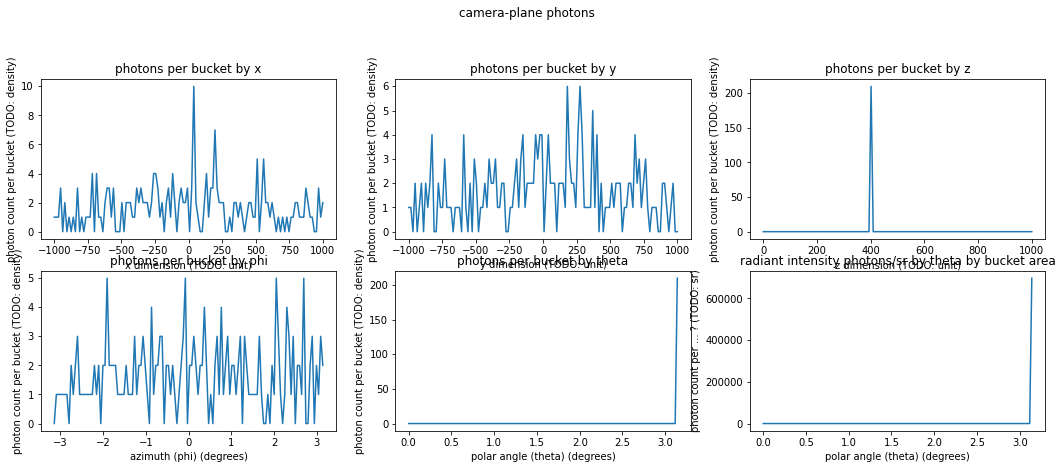

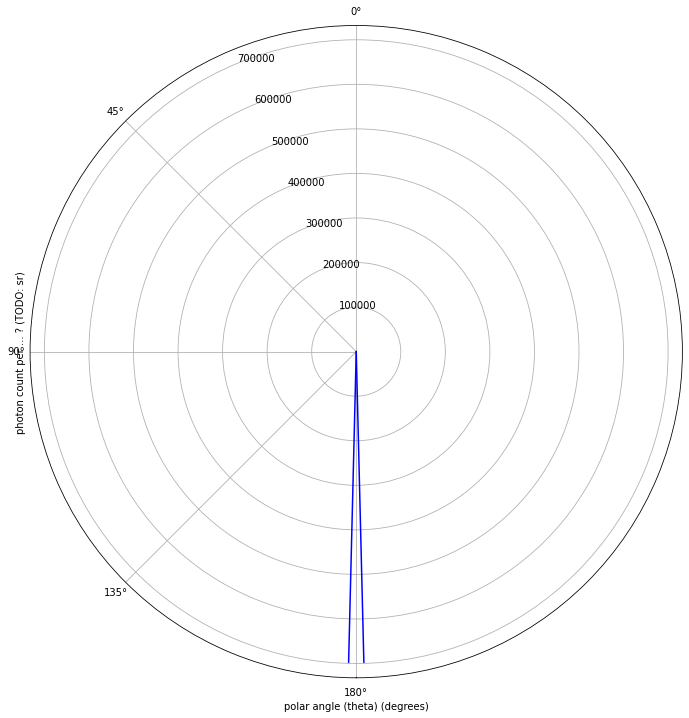

In [23]:
%%time
#DONE
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons",
                      x_min=-1000, x_max=1000,
                      y_min=-1000, y_max=1000,
                      z_min=0, z_max=1000)

In [24]:
%%time
#DONE
camera_sample = photons.sample()

CPU times: user 1.6 ms, sys: 0 ns, total: 1.6 ms
Wall time: 462 µs


In [25]:
%%time
#DONE
""" Show the reflected photons in 3d."""
# lightbox is -200,200, camera is 1cm so -50,50 but offset to the side.
camera_box = [200, 300, -50, 50, lightbox_height]
plot_3d([camera_sample],
        ray_lengths=[100],
        boxes=[diff_box, camera_box],
        labels=['diffuser','camera'],
        colors=[0x00ff00, 0xff00ff])

Output()

CPU times: user 65.4 ms, sys: 11.8 ms, total: 77.3 ms
Wall time: 35 ms
